In [1]:
# ============ Set Seed ============
def set_seed(seed=42):
    # Set random seed for reproducibility across libraries
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ============ Dataset ============
class Twitter15Dataset(Dataset):
    def __init__(self, graph_data_list):
        """
        Custom PyTorch Dataset for Twitter15 graph data.
        Each graph is a dictionary containing 'x' (features),
        'edge_index' (graph connectivity), and 'y' (label).
        """
        self.graphs = graph_data_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        x = graph['x']
        edge_index = graph['edge_index']
        y = graph['y']
        return x, edge_index, y

def collate_fn(batch):
    """
    Custom collate function for batching variable-length graph data.
    Pads node features and masks them appropriately. Also offsets edge indices.
    """
    xs, edge_indices, ys = zip(*batch)
    max_len = max(x.shape[0] for x in xs)
    feature_dim = xs[0].shape[1]

    padded_xs, masks, edge_indices_new = [], [], []

    for i, (x, edge_index) in enumerate(zip(xs, edge_indices)):
        seq_len = x.shape[0]
        pad_len = max_len - seq_len

        # Pad the node features
        x_padded = torch.cat([x, torch.zeros((pad_len, feature_dim), dtype=x.dtype)], dim=0) if pad_len > 0 else x

        # Mask indicating valid node positions
        mask = torch.cat([torch.ones(seq_len), torch.zeros(pad_len)]).bool()

        # Offset edge indices to avoid overlap across graphs in batch
        edge_index_offset = edge_index.clone()
        edge_index_offset += i * max_len

        padded_xs.append(x_padded)
        masks.append(mask)
        edge_indices_new.append(edge_index_offset)

    return (
        torch.stack(padded_xs),
        torch.stack(masks),
        torch.cat(edge_indices_new, dim=1),
        torch.tensor(ys)
    )

# ============ Model ============

# GCN-based encoder for graph structure
class GraphEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gcn = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, mask, edge_index):
        B, L, D = x.size()
        x_flat = x.view(B * L, D)

        # Apply mask before GCN
        mask_flat = mask.view(B * L).unsqueeze(-1).to(x.dtype)
        x_flat = x_flat * mask_flat

        # Run GCN if graph has edges
        h_flat = self.gcn(x_flat, edge_index) if edge_index.numel() > 0 else x_flat

        # Apply mask after GCN
        h_flat = h_flat * mask_flat
        return h_flat.view(B, L, D)

# Wrapper for a single Mamba layer with dropout
class MambaLayer(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super().__init__()
        self.mamba = Mamba(d_model=hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.mamba(x))

# Stacked Mamba-based encoder
class MambaEncoder(nn.Module):
    def __init__(self, input_dim=833, hidden_dim=128, num_layers=2, dropout_rate=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList([
            MambaLayer(hidden_dim, dropout_rate) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask):
        x = self.input_proj(x)
        mask_f = mask.unsqueeze(-1).to(x.dtype)
        x = x * mask_f

        for layer in self.layers:
            x = layer(x)
            x = x * mask_f

        return self.norm(x)

# Mean pooling over masked sequences
class MeanPooling(nn.Module):
    def forward(self, x, mask):
        mask = mask.unsqueeze(-1)
        x = x * mask
        sum_x = x.sum(dim=1)
        lengths = mask.sum(dim=1)
        return sum_x / lengths.clamp(min=1e-6)

# Classification head with ReLU nonlinearity
class ClassifierHead(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Combined model: Mamba + GNN + Pooling + Classification
class MambaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.encoder = MambaEncoder(input_dim, hidden_dim, num_layers)
        self.gnn_encoder = GraphEncoder(hidden_dim)
        self.pooling = MeanPooling()
        self.classifier = ClassifierHead(hidden_dim, num_classes)

    def forward(self, x, mask, edge_index):
        x = self.norm(x)
        h_seq = self.encoder(x, mask)
        h_graph = self.gnn_encoder(h_seq, mask, edge_index)
        h = h_seq + 0.3 * h_graph  # Combine sequence and graph features
        pooled = self.pooling(h, mask)
        logits = self.classifier(pooled)
        return torch.clamp(logits, min=-10, max=10)  # Avoid extreme values

# ============ Loss Function ============

# Label smoothing cross-entropy loss
def smooth_cross_entropy(preds, targets, smoothing=0.1):
    confidence = 1.0 - smoothing
    logprobs = F.log_softmax(preds, dim=-1)
    nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
    smooth_loss = -logprobs.mean(dim=-1)
    return (confidence * nll_loss + smoothing * smooth_loss).mean()

# ============ Training & Evaluation ============

# One training epoch
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for x, mask, edge_index, y in train_loader:
        x, mask, y = x.to(device), mask.to(device), y.to(device)
        edge_index = edge_index.to(device)
        x = torch.nan_to_num(x, nan=0.0)  # Replace NaNs

        optimizer.zero_grad()
        logits = model(x, mask, edge_index)

        # Skip unstable batches
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            continue

        loss = loss_fn(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        all_preds.extend(logits.argmax(dim=-1).detach().cpu().tolist())
        all_labels.extend(y.cpu().tolist())

    avg_loss = running_loss / len(train_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1

# One evaluation epoch
def evaluate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, mask, edge_index, y in val_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            edge_index = edge_index.to(device)

            logits = model(x, mask, edge_index)
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                continue

            loss = loss_fn(logits, y)
            running_loss += loss.item() * x.size(0)

            all_preds.extend(logits.argmax(dim=-1).cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    avg_loss = running_loss / len(val_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1


Train: 1043, Val: 223, Test: 224

>>> Trying lr=5e-05, weight_decay=0.01
Epoch 1:
  Train Loss: 1.3845 | Train Acc: 0.2464 | Train F1: 0.2141
  Val   Loss: 1.1884 | Val   Acc: 0.2199 | Val   F1: 0.1512
Epoch 2:
  Train Loss: 1.3704 | Train Acc: 0.3471 | Train F1: 0.2692
  Val   Loss: 1.1761 | Val   Acc: 0.3141 | Val   F1: 0.2520
Epoch 3:
  Train Loss: 1.3353 | Train Acc: 0.4056 | Train F1: 0.3327
  Val   Loss: 1.1536 | Val   Acc: 0.3665 | Val   F1: 0.2914
Epoch 4:
  Train Loss: 1.2873 | Train Acc: 0.4305 | Train F1: 0.3763
  Val   Loss: 1.1464 | Val   Acc: 0.3770 | Val   F1: 0.3376
Epoch 5:
  Train Loss: 1.2409 | Train Acc: 0.4823 | Train F1: 0.4603
  Val   Loss: 1.1147 | Val   Acc: 0.4084 | Val   F1: 0.3709
Epoch 6:
  Train Loss: 1.1909 | Train Acc: 0.5340 | Train F1: 0.5169
  Val   Loss: 1.1148 | Val   Acc: 0.4450 | Val   F1: 0.4124
Epoch 7:
  Train Loss: 1.1407 | Train Acc: 0.5427 | Train F1: 0.5159
  Val   Loss: 1.1565 | Val   Acc: 0.4084 | Val   F1: 0.4078
EarlyStopping counter: 1

### Step 5 Test Evaluation

Test Accuracy: 0.6429
Test Macro-F1: 0.6426


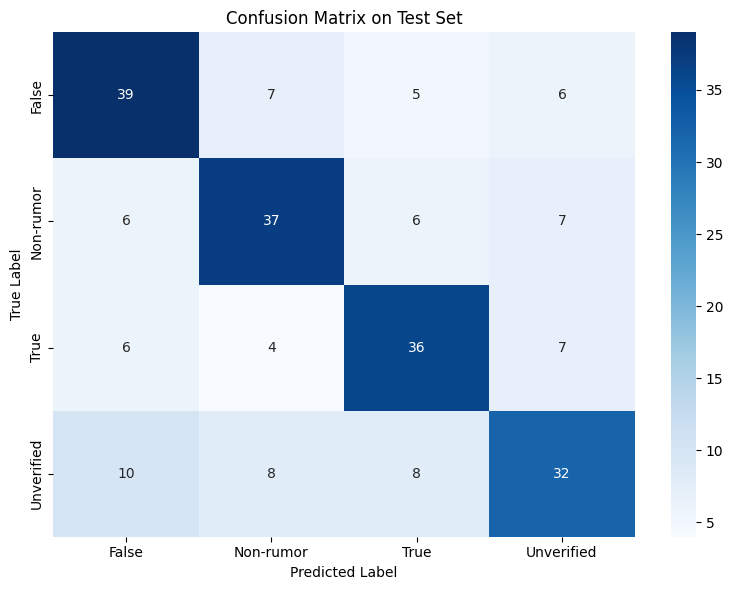

In [59]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load the best model
model.load_state_dict(torch.load("../checkpoints/best_model_v3.pt"))  # Load the trained model weights
model.to(device)       # Move the model to the computation device (e.g., GPU or CPU)
model.eval()           # Set the model to evaluation mode

all_preds = []         # To store predicted labels
all_labels = []        # To store true labels

# 2. Run inference on the test set
with torch.no_grad():  # Disable gradient computation for faster inference
    for x, mask, edge_index, y in test_loader:
        # Move data to the device
        x = x.to(device)
        mask = mask.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)

        logits = model(x, mask, edge_index)  # Forward pass
        preds = logits.argmax(dim=-1)        # Get predicted class indices

        all_preds.extend(preds.cpu().tolist())   # Store predictions
        all_labels.extend(y.cpu().tolist())      # Store ground truth labels

# 3. Compute Accuracy and Macro F1 Score
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")

# 4. Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["False", "Non-rumor", "True", "Unverified"],
            yticklabels=["False", "Non-rumor", "True", "Unverified"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()
